In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS,MCMC,Predictive

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
plt.rcParams['font.size'] = 12

## Load & Check Data

In [4]:
y = np.array([
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0])

In [5]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0
 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 2 2 0 0 0 1 0 0 1 0 3 1 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0]


In [ ]:
np.mean(y) # is very small

np.float64(0.19)

In [7]:
np.var(y)

np.float64(0.3039)

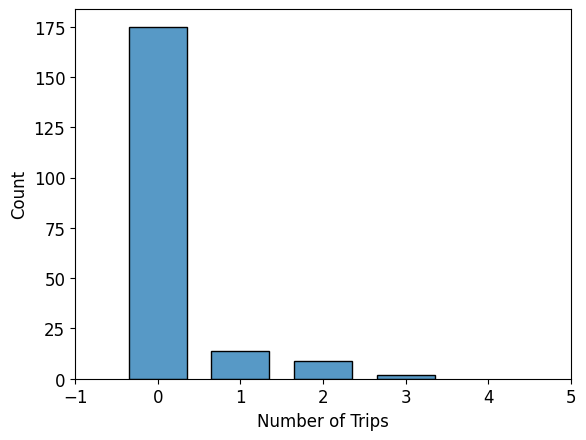

In [8]:
sns.histplot(y, discrete=True, shrink=0.7)

plt.xlim(-1, 5)
plt.xlabel('Number of Trips');

## Define Model & Inference

In [9]:
def model(y=None, num_data=0):
    
    mu = numpyro.sample('mu', dist.HalfNormal(10))
    
    with numpyro.plate('data', num_data):
    
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

In [10]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

## Check MCMC-samples

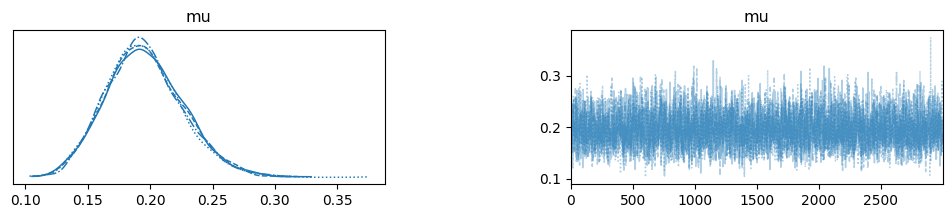

In [11]:
az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.195,0.031,0.136,0.252,0.0,0.0,4250.0,5981.0,1.0


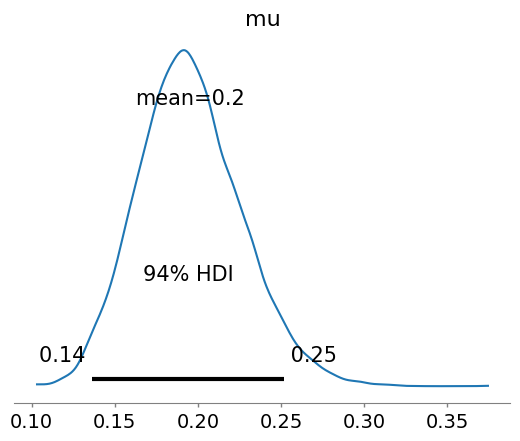

In [13]:
az.plot_posterior(idata);

## Posterior Predictive Check

In [14]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), num_data=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

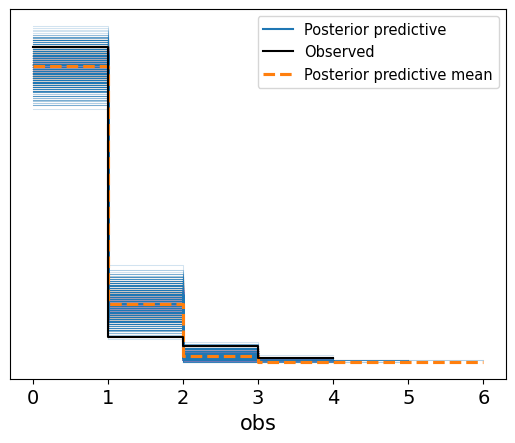

In [15]:
az.plot_ppc(idata_ppc, num_pp_samples=1000);

## Save Inference Data

In [16]:
idata.to_netcdf('idata.nc')

'idata.nc'